In [31]:
import os
from threading import Thread  # for running the denoiser in parallel
import queue  # 队列

import numpy as np
import torch
import torch.optim
from models.skip import skip  # our network

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time

from skimage.restoration import denoise_nl_means
from dncnn_models.network_dncnn import DnCNN as net # dncnn net
from dncnn_models.network_ffdnet import FFDNet as net_ffdnet    # FFDNet

import warnings
warnings.filterwarnings("ignore")

# got GPU? - if you are not getting the exact article results set CUDNN to False
CUDA_FLAG = True
CUDNN = True
if CUDA_FLAG:
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    torch.backends.cudnn.enabled = CUDNN
    torch.backends.cudnn.benchmark = CUDNN
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
    
# graphs labels:
X_LABELS = ['Iterations']*3
Y_LABELS = ['PSNR between x and net (db)', 'PSNR with original image (db)', 'loss']

# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL = 'Clean'
MASK='Mask'
CORRUPTED = 'Noisy'
NLM = 'NLM'
DIP_NLM = 'DRED (NLM)'


DnCNN=  'DnCNN'
FFDnet= 'FFDnet'

DIP_NLM =   'DRED (NLM)'
DIP_BM3D=   'DRED (BM3D)'
DIP_DNCNN=  'DRED (DNCNN)'
DIP_FFDNET= 'DIP_FFDNET'
DIP_TEMP    = 'DIP_TEMP'


In [32]:
# load image for inpainting on mixed degradation(YUAN)
def load_image_inpainting_new(fclean_path,mask_path, fnoisy=True, sigma=25, plot=False):
    """ 
        fname - input file name
        d - Make dimensions divisible by `d`
        sigma - the amount of noise you want to add noise to the image
        Return a numpy image, and a noisy numpy image with sigma selected
    """
    img_pil, img_np           = load_and_crop_image(fclean_path)
    img_mask_pil, img_mask_np = load_and_crop_image(mask_path)

    # mask随着image.size调整大小
    img_mask_pil = img_mask_pil.resize(img_pil.size, Image.BICUBIC)
    img_mask_np = pil_to_np(img_mask_pil)
    
    # 图像要先乘mask:
    hx=img_np*(img_mask_np)
    # 然后再加噪：
    hx_n = np.clip(hx + np.random.normal(scale=sigma / 255., size=hx.shape), 0, 1).astype(np.float32)
    #hx_n = np.clip(hx + np.random.poisson(sigma/255, size=hx.shape), 0, 1).astype(np.float32) # lam>=0 值越小，噪声频率就越少
    data_dict = {ORIGINAL: Data(img_np), MASK:Data(img_mask_np),CORRUPTED: Data(hx_n, compare_psnr(img_np, hx_n))}

    if plot:
        plot_dict(data_dict)
    return data_dict

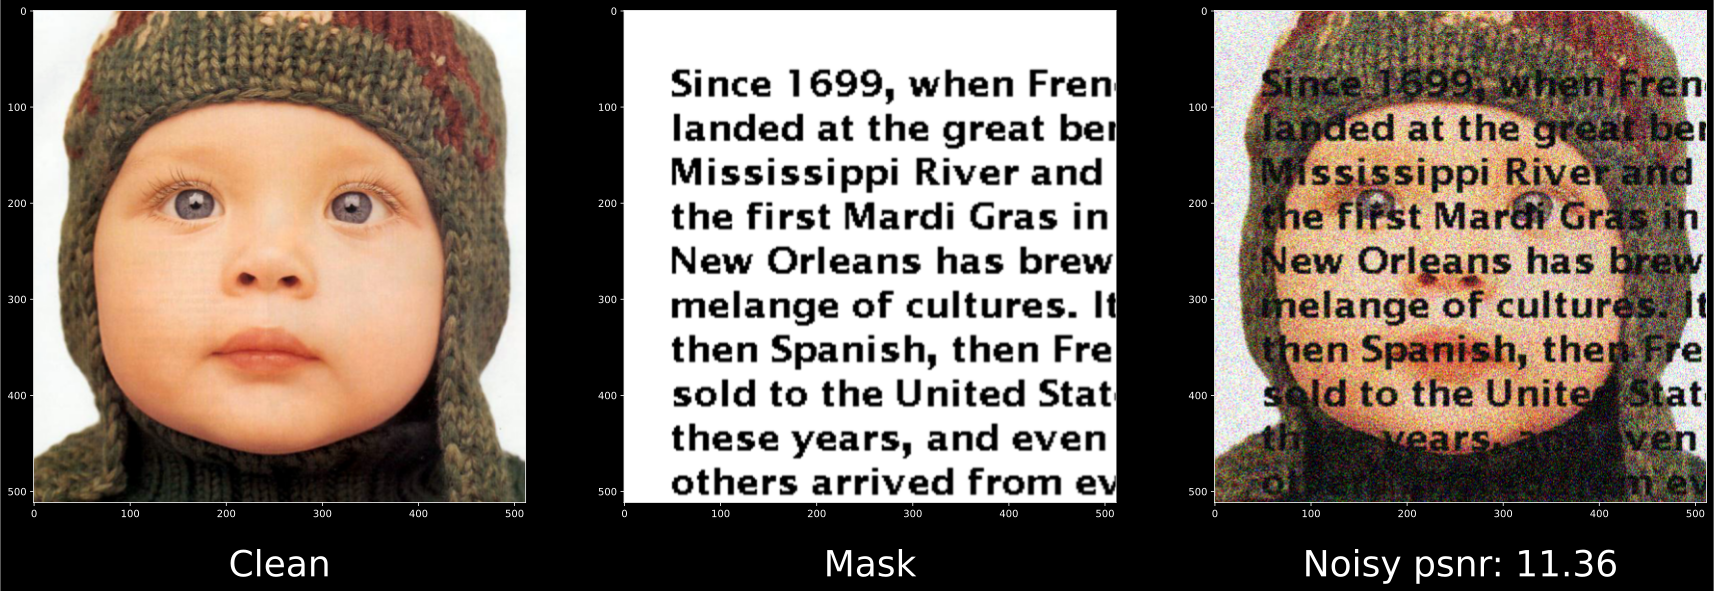

In [33]:
# 常规图像测试部分：
SIGMA = 50 # small:10, medium:25, heavy:50
# 图像的路径
imgpath ='/home/yuanweimin/PHD_3/YUAN_LASTEST_WORK/all_data/testsets/set5/baby.bmp'
# mask的路径：
maskpath='/home/yuanweimin/PHD_3/YUAN_LASTEST_WORK/all_data/Test_Images/TextMask.png'
data_dict = load_image_inpainting_new(imgpath,maskpath, sigma=SIGMA, plot=True)

In [34]:
# y=data_dict[CORRUPTED].img
# plt.imsave('./INPUT.png',y.transpose(1,2,0))

In [35]:
def get_network_and_input(img_shape, input_depth=32, pad='reflection',
                          upsample_mode='bilinear', use_interpolate=True, align_corners=False,
                          act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4,
                          num_scales=5, downsample_mode='stride', INPUT='noise'):  # 'meshgrid'
    """ Getting the relevant network and network input (based on the image shape and input depth)
        We are using the same default params as in DIP article
        img_shape - the image shape (ch, x, y)
    """
    n_channels = img_shape[0]
    net = skip(input_depth, n_channels,
               num_channels_down=[skip_n33d] * num_scales if isinstance(skip_n33d, int) else skip_n33d,
               num_channels_up=[skip_n33u] * num_scales if isinstance(skip_n33u, int) else skip_n33u,
               num_channels_skip=[skip_n11] * num_scales if isinstance(skip_n11, int) else skip_n11,
               upsample_mode=upsample_mode, use_interpolate=use_interpolate, align_corners=align_corners,
               downsample_mode=downsample_mode, need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)
    net_input = get_noise(input_depth, INPUT, img_shape[1:]).type(dtype).detach()
    return net, net_input

In [36]:
# 处理rgb图像：

n_channels_color=3  #处理单通道图像
# 实例化：
model_ffdnet_color=net_ffdnet(in_nc=n_channels_color,out_nc=n_channels_color,nc=96,nb=12,act_mode='R')
#预训练的FFDNet模型参数：(使用绝对路径！)
model_path_ffdnet_color='/home/yuanweimin/PHD_3/2019_ICCVW_DeepRED/model_zoo/ffdnet_color.pth'

#加载训练参数：
model_ffdnet_color.load_state_dict(torch.load(model_path_ffdnet_color),strict=True)
model_ffdnet_color.eval()
#通常在实际代码中，在预测阶段，也会加上torch.no_grad()来关闭梯度的计算
for k, v in model_ffdnet_color.named_parameters():
    v.requires_grad = False

def FFDNet_color_yuan(noisy_np_img,sigma):
    noisy_torch_img=np_to_torch(noisy_np_img)

    n_channels=noisy_torch_img.shape[1]
    denoised_img=[]
    sigma_map=torch.full((1,1,1,1),sigma/255.).type_as(noisy_torch_img) # size:[1,1,1,1]
    denoise_torch_fast=model_ffdnet_color(noisy_torch_img,sigma_map)                # denoise_torch_fast:[1,1,256,256]
    
    denoise_np_fast=torch_to_np(denoise_torch_fast)       # denoise_np_fast:[1,256,256]
    #print(denoise_np_fast.shape)
    denoised_img+=[denoise_np_fast]   
    return np.array(denoised_img, dtype=np.float32)

In [37]:
def train_via_admm(net, net_input, denoiser_function, y, mask, HR_img=None,  # D is the downsampler, y is LR image
                   plot_array={}, algorithm_name="", save_path="",          # will save params and graphs in this folder
                   admm_iter=3000, LR=0.001, update_iter=10, method='fixed_point',   # 'fixed_point' or 'grad' or 'mixed'
                   # sigma_f:FFDNET先验的输入参数
                   sigma_f=25, beta=0.05, mu=0.06, LR_x=None, noise_factor=.02):    # LR_x needed only if method!=fixed_point
    
    # get optimizer and loss function:
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # using ADAM opt

    mse = torch.nn.MSELoss().type(dtype)  # using MSE loss

    # additional noise added to the input:
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    
    # x update method:
    if method == 'fixed_point':
        swap_iter = admm_iter + 1
        LR_x = None
    elif method == 'grad':
        swap_iter = -1
    elif method == 'mixed':
        swap_iter = admm_iter // 2
    else:
        assert False, "method can only be 'fixed_point' or 'grad' or 'mixed' !"
        
    # initialize:
    x = np.zeros_like(y)  # bicubic.copy()

    y_torch = np_to_torch(y).type(dtype) # y 就是DIP进行超分的目标(y_torch是其tensor)
    mask_torch = np_to_torch(mask).type(dtype)

    f_x = x.copy()

    # 拉格朗日乘子U初始化：
    u = np.zeros_like(x)

    psnr_net_list=[]
    psnr_hr=[]
    image_list=[]

    for i in range(1, 1 + admm_iter):

        # step 1, update network, eq. 7 in the article
        optimizer.zero_grad()
        net_input = net_input_saved + (noise.normal_() * noise_factor)
        out = net(net_input)
        out_np = torch_to_np(out)
        
        # loss:
        loss_y = mse(out*mask_torch, y_torch)
        
        loss_x = mse(out, np_to_torch(x - u).type(dtype))
        total_loss = loss_y + mu * loss_x  # SR任务上总的loss
        total_loss.backward()
        optimizer.step()
        
        # step 2, update x using a denoiser and result from step 1
        f_x = denoiser_function(x.copy(), sigma_f)

        # 因为随着迭代噪声变小，减少sigma_f的影响
        #sigma_f = sigma_f - 0.0001

        # 使用深度先验的话需要去掉一维：
        f_x=np.squeeze(f_x)
        
        # step 2, update x using a the denoiser (f_x) and network outputs (out_np)
        if i < swap_iter:
            x = 1 / (beta + mu) * (beta * f_x + mu * (out_np + u))      # eq. 11 in the article
        else:
            x = x - LR_x * (beta * (x - f_x) + mu * (x - out_np - u))   # eq. 12 in the article
        np.clip(x, 0, 1, out=x)  # making sure that image is in bounds

        # step 3, update u
        u = u + out_np - x

        increase_reg= 0
        mu = mu + increase_reg
        beta = beta + increase_reg
        
        # show psnrs:
        if HR_img is not None:
            
            psnr_net = compare_PSNR(HR_img, out_np, on_y=True)   # psnr of network output
            psnr_x_u = compare_PSNR(HR_img, x - u,  on_y=True)    # the psnr of our result
            
            # 记录结果：
            psnr_hr.append(psnr_x_u)       # 最终的结果psnr
            psnr_net_list.append(psnr_net)
            image_list.append(x-u)         # 最终的结果image
            
            print('\r', algorithm_name, '%04d/%04d Loss %f' % (i, admm_iter, total_loss.item()),
                  'psnr net: %.2f psnr x-u: %.2f' % (psnr_net, psnr_x_u), end='')
        else:
            print('\r', algorithm_name, 'iteration %04d/%04d Loss %f' % (i, admm_iter, total_loss.item()), end='')
    
    return (x - u), psnr_hr,psnr_net_list,image_list


In [38]:
def run_and_plot(denoiser, name, plot_checkpoints={}):
    global data_dict
    # get net, input
    net, net_input = get_network_and_input(img_shape=data_dict[ORIGINAL].img.shape)
    
                                # 在此处测试有无噪声的输入：CORRUPTED or MIXEDCORRUPTED
    # run the generic function: # D, y: data_dict[CORRUPTED/MIXEDCORRUPTED].img
    sr_img, psnr_hr,psnr_net_list,image_list = train_via_admm(net, net_input, denoiser, y=data_dict[CORRUPTED].img,
                                                              mask=data_dict[MASK].img,
                                                              HR_img=data_dict[ORIGINAL].img,
                                                              plot_array=plot_checkpoints, algorithm_name=name)
    
    data_dict[name] = Data(sr_img, compare_PSNR(data_dict[ORIGINAL].img, sr_img, on_y=True))
    #plot_dict(data_dict)

    return sr_img,psnr_hr,psnr_net_list,image_list 

plot_checkpoints = {1, 10, 100, 1000, 1500}
#                     denoiser choice: non_local_means, bm3d_yuan, DnCNN_yuan, FFDNet_yuan
#                                      DIP_NLM,         DIP_BM3D,  DIP_DNCNN,  DIP_FFDNET 
#   FFDNet_gray_yuan 
#   FFDNet_color_yuan
sr_img,psnr_hr,psnr_net_list,image_list = run_and_plot(FFDNet_color_yuan, DIP_TEMP, plot_checkpoints)



 DIP_TEMP 3000/3000 Loss 0.019539 psnr net: 23.44 psnr x-u: 26.62

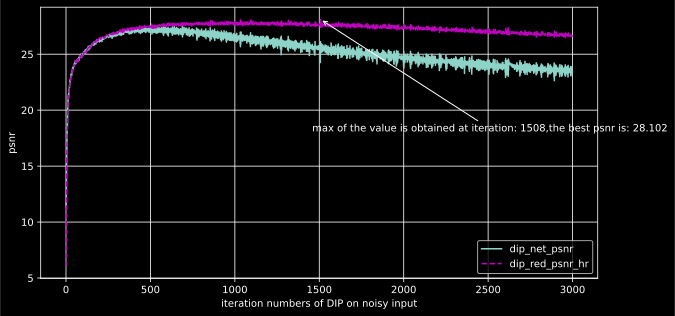

In [39]:
# part1: 总的PSNR曲线：
from d2l import torch as d2l
import matplotlib.pyplot as plt
#from scipy.misc import imread, imsave
import imageio

# 获取psnr_avg_list列表的最大值和对应索引
net_max=max(psnr_hr)                       
net_max_index=psnr_hr.index(net_max)   

#标注函数
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,arrowprops=dict(arrowstyle='->'))

x=torch.arange(0,3000,1)
d2l.plot(x.numpy(),[psnr_net_list,psnr_hr],xlabel='iteration numbers of DIP on noisy input',ylabel='psnr',legend=['dip_net_psnr','dip_red_psnr_hr'],figsize=(10,5))
text_label='max of the value is obtained at iteration: '+str(net_max_index)+','+'the best psnr is: '+str(round(net_max,3))
annotate(text=text_label,xy=(net_max_index,net_max),xytext=(net_max_index-50,net_max-10))

# part2: 显示最优的那张结果：
optimal_img=image_list[net_max_index]
data_dict[DIP_TEMP] = Data(optimal_img, compare_PSNR(data_dict[ORIGINAL].img, optimal_img, on_y=True))
plot_dict(data_dict)

In [43]:
import pandas as pd
df=pd.DataFrame(psnr_hr,columns=['psnr'])
df.to_excel('psnr_ours.xlsx',index=False)

In [40]:
# optimal_img=np.squeeze(optimal_img)
# optimal_img.shape

# np.clip(optimal_img, 0, 1, out=optimal_img) 
# plt.imsave('YUAN.png',optimal_img,cmap='gray')

In [41]:
# import matplotlib.pyplot as plt
# np.clip(optimal_img, 0, 1, out=optimal_img) 

# # INPUT: data_dict[CORRUPTED].img
# plt.imsave('./YUAN.png',(optimal_img).transpose(1,2,0))